<a href="https://colab.research.google.com/github/knobs-dials/wetsuite-datacollect/blob/main/rechtspraaknl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose of this notebook

Understanding what you can get out of [rechtspraak.nl](https://www.rechtspraak.nl/).

Note that this is mostly just showing our work. If the rechtspraak [dataset](../../intro/wetsuite_datasets.ipynb) we provide suits your needs,
then running this notebook would just be a slower and more cumbersome way to get basically the same.

Somewhat related: [extras_datacollect_rechtspraak_codes](extras_datacollect_rechtspraak_codes.ipynb)

## Website, Open data API, and some other notes

You are probably familiar with the [rechtspraak.nl](https://rechtspraak.nl) website, and possibly its [search that has a number of filters](https://uitspraken.rechtspraak.nl/#!/) (and some [exta query logic for the text](https://www.rechtspraak.nl/Uitspraken/Paginas/Hulp-bij-zoeken.aspx#1ab85aa0-e737-4b56-8ad5-d7cb7954718d77a998be-3c73-40e3-90f7-541fceeb00fd3)), which gives webpage results, with text where present.


There is also an [Open Data van de Rechtspraak](https://www.rechtspraak.nl/Uitspraken/Paginas/Open-Data.aspx), an API that exposes much the same in data form.
As [its documentation](https://www.rechtspraak.nl/SiteCollectionDocuments/Technische-documentatie-Open-Data-van-de-Rechtspraak.pdf) ([this intro](https://www.rechtspraak.nl/Uitspraken/paginas/open-data.aspx) may also be useful) mentions,
- you stick query parameters on the base URL of http://data.rechtspraak.nl/uitspraken/zoeken 
- the results mainly mention ECLIs, which you can fetch details for via e.g. https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:PHR:2011:BP5608 (more notes below)


Worthy of note:
- the fields you can search mostly matches with the 'Uitgebreid zoeken' at uitspraken.rechtspraak.nl, like
  - instantie / court code (basically that third element in the ECLI)
  - rechtsgebied
  - procedure

- **You can't search in the body text**.  This largely limits the API to a 'keep updated with new cases' feed.
  - Worthy of note: the website search (queried via `https://uitspraken.rechtspraak.nl/api/zoek`) does support this, and even seems like a better data API than the _actual_ data API one -- but it doesn't look like it's supposed to be used externally.

- there are plenty of cases where there is no text / document.  You can filter for this in the search.

- the **identifiers** used are **ECLI** (European Case Law Identifier)
  - which in this case will be mainly Dutch ECLIs  (`ECLI:NL:`...), used since 2013 or so, and which absorbed the previously used LJN identifiers.
  - court code XX (`ECLI:NL:XX:`...) is used for things not (yet?) assgined to a court, and/or non-Dutch ECLIs,
    - rechtspraak.nl may later resolve such ECLIs to a different ECLI. That makes their site the most up-to-date information, that a mirror may not necessarily be aware of (yet). 
    - Example: ECLI:NL:XX:2009:BJ4574 
      - in [XML metadata](https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:XX:2009:BJ4574) mentions it's now (isReplacedBy) ECLI:CE:ECHR:2009:0528JUD002671305
      - in [webpage form](https://uitspraken.rechtspraak.nl/#!/details?id=ECLI:NL:XX:2009:BJ4574) also seems to link to [a place to find it](https://hudoc.echr.coe.int/eng#%7B%22ecli%22:%5B%22ECLI:CE:ECHR:2009:0528JUD002671305%22%5D%7D) (e.g. `hudoc.echr.coe.int` or `e-justice.europa.eu`).

For each ECLI you might consider various URLs, including
  - XML, e.g. at https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:PHR:2011:BP5608
    - most interesting when you want case details as data
    - (there is a different XML form at https://uitspraken.rechtspraak.nl/api/document/?id=ECLI:NL:PHR:2011:BP5608 but this is for the webpage view, and is less interesting as data)
  - the case on the website
    - is linked by the website as   https://uitspraken.rechtspraak.nl/InzienDocument?id=ECLI:NL:PHR:2011:BP5608
    - it seems the slightly shorter https://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:PHR:2011:BP5608 is equivalent
    - both of the above redirect to a URL like https://uitspraken.rechtspraak.nl/#!/details?id=ECLI:NL:PHR:2011:BP5608
      - which is a general page with scripting that picks up that identifer and then does another request to https://uitspraken.rechtspraak.nl/api/document/?id=ECLI:NL:PHR:2011:BP5608 (the webpage-view variant mentioned earlier)
  - The website also often links to LiDo, e.g.  https://linkeddata.overheid.nl/document/ECLI:NL:PHR:2011:BP5608
    - If you want that as data, consider http://linkeddata.overheid.nl/service/get-links?ext-id=ECLI:NL:PHR:2011:BP5608&output=xml
    - though as https://linkeddata.overheid.nl/front/portal/services notes, this is not part of public LiDo, so you'll need to request an account first


Because there are over three million dutch ECLIs on record, getting a lot of data from here would take a while, and they ask you to be nice to their server.

There used to be a ZIP file (linked from [https://www.rechtspraak.nl/Uitspraken/paginas/open-data.aspx](https://www.rechtspraak.nl/Uitspraken/paginas/open-data.aspx) you could download to bootstrap your own copy. This seems to have been removed, as [this open data request](https://data.overheid.nl/community/datarequest/zip-bestand-alle-uitspraken) seems to confirm. It seems to imply that you should get it the hammery way.
(As of this writing the URL to the ZIP file still works but they probably removed the link for a reason)

In [1]:
import collections
import random
import time
import datetime

import wetsuite.helpers.date
import wetsuite.helpers.etree
import wetsuite.datacollect.rechtspraaknl
import wetsuite.helpers.koop_parse
import wetsuite.helpers.meta
import wetsuite.helpers.net
import wetsuite.helpers.localdata
import wetsuite.helpers.notebook

### Example of API search, its results, and fetching

#### Querying 

The base URL for data is http://data.rechtspraak.nl/uitspraken/.

Browsing to just that will link you to some identifier/value lists.

The **search** base is http://data.rechtspraak.nl/uitspraken/zoeken

Search parameters include: (again, see [the documentation](https://www.rechtspraak.nl/SiteCollectionDocuments/Technische-documentatie-Open-Data-van-de-Rechtspraak.pdf))
* from, max  (from is 0-based, max value of max is documented as 1000)
* sort - default is by modification date, ascending. `DESC` lets you do descending instead.
* type - `Uitspraak` or `Conclusie`
* date - date of this uitspraak / conclusie
* uitspraakdatum (date, or date range; optional)
* instantie - as mentioned in https://data.rechtspraak.nl/Waardelijst/Instanties 
* subject - rechtsgebied as mentioned in https://data.rechtspraak.nl/Waardelijst/Rechtsgebieden
* return - if you specify return=DOC you only get entries for which there is a document; if not you also get entries for which there is only metadata
* modified - last change of the metadata and/or text (with some subtleties, e.g. not necessarily of the uitrspraak or conclusie document)
* replaces - previous ECLI, or LJN,. for this case.  Meant for backwards compatibility (of searches?).


For example: http://data.rechtspraak.nl/uitspraken/zoeken?modified=2023-01-01&max=50

The response format is [Atom](https://en.wikipedia.org/wiki/Atom_(standard)) and entries are minimal: title, date, summary, and an URL pointing at the XML data  

        <entry>
            <id>ECLI:NL:RBAMS:2021:8211</id>
            <title type="text">ECLI:NL:RBAMS:2021:8211, Rechtbank Amsterdam, 29-06-2021, C/13/702999 / KG ZA 21-458</title>
            <summary type="text"/>
            <updated>2023-01-04T15:21:26Z</updated>
            <link rel="alternate" type="text/html" href="https://uitspraken.rechtspraak.nl/details?id=ECLI:NL:RBAMS:2021:8211"/>
        </entry>

...but let's get our code to help:

In [21]:
## First get the search result metadata

overall_entries = {}

at_a_time = 1000
for range_from, range_to in wetsuite.helpers.date.date_ranges(
        from_date=wetsuite.helpers.date.date_weeks_ago(550), # or e.g. '2024-01-01',
        to_date  =wetsuite.helpers.date.date_weeks_ago(450),      
        #from_date=wetsuite.helpers.date.date_weeks_ago(2), # or e.g. '2024-01-01',
        #to_date  =wetsuite.helpers.date.date_today(),      
        increment_days=1, strftime_format="%Y-%m-%d"):
    #print()
    from_position = 0
    while True:
        query = [
            ('from', str(from_position)),  
            ('max',  str(at_a_time)),     # max seems capped at 1000, so we have to do more in multiple fetches
            #('return', 'DOC'),                                          # DOC asks for things with body text only
            #('modified', '2023-12-28'),
        ]
        query.extend( [('modified',range_from), ('modified',range_to)] )
        print('Querying:', query)

        search_results = wetsuite.datacollect.rechtspraaknl.search( query )
        # search_results is a parsed etree object.
        # We could show that relatively raw like    
        #print( wetsuite.helpers.etree.debug_pretty(search_results) ) 
        #  yet our parsed form (each entry as a dict) is little simpler to read:

        search_entries = wetsuite.datacollect.rechtspraaknl.parse_search_results( search_results )
        # we could make overall_entries a list and just extend() it, but there would probably be a lot of overlap,
        # so instead we use the ECLI to deduplicate
        #print('adding %d entries'%len(search_entries))
        for entry_dict in search_entries:
            overall_entries[ entry_dict.get('ecli') ] = entry_dict 

        if len(search_results) < 1000: # last bunch?
            break
        # otherwise go on to fetch next page
        from_position += at_a_time

    print( "Cumulative query results: %d"%len(overall_entries) )
    #for entry in random.sample( overall_entries, 3 ): # show a few random examples
    #    print('--------------------')
    #    pprint.pprint(entry)


Querying: [('from', '0'), ('max', '1000'), ('modified', '2013-08-01'), ('modified', '2013-08-02')]
Cumulative query results: 187
Querying: [('from', '0'), ('max', '1000'), ('modified', '2013-08-02'), ('modified', '2013-08-03')]
Cumulative query results: 289
Querying: [('from', '0'), ('max', '1000'), ('modified', '2013-08-03'), ('modified', '2013-08-04')]
Cumulative query results: 289
Querying: [('from', '0'), ('max', '1000'), ('modified', '2013-08-04'), ('modified', '2013-08-05')]
Cumulative query results: 289
Querying: [('from', '0'), ('max', '1000'), ('modified', '2013-08-05'), ('modified', '2013-08-06')]
Cumulative query results: 446
Querying: [('from', '0'), ('max', '1000'), ('modified', '2013-08-06'), ('modified', '2013-08-07')]
Cumulative query results: 701
Querying: [('from', '0'), ('max', '1000'), ('modified', '2013-08-07'), ('modified', '2013-08-08')]
Cumulative query results: 824
Querying: [('from', '0'), ('max', '1000'), ('modified', '2013-08-08'), ('modified', '2013-08-09')

#### Fetching the documents the search refers to

In [8]:
rechtspraak_fetched = wetsuite.helpers.localdata.LocalKV('rechtspraak_fetched.db', key_type=str, value_type=bytes)

In [2]:
## Now get the text belonging to each
paths = collections.defaultdict(int)

count_fetched, count_cached = 0,0

pbar = wetsuite.helpers.notebook.progress_bar( len(overall_entries), description='fetching... ')

for entry in overall_entries.values():
    entry_xml_url = 'https://data.rechtspraak.nl/uitspraken/content?id=%s'%entry['ecli']
    # TODO: timeout catch
    bytestring, came_from_cache = wetsuite.helpers.localdata.cached_fetch( rechtspraak_fetched, entry_xml_url)
    if came_from_cache:
        count_cached +=1
    else:
        count_fetched += 1
        #time.sleep(1) # be somewhat nicer to the servers
    
    tree  = wetsuite.helpers.etree.fromstring( bytestring )
    tree  = wetsuite.helpers.etree.strip_namespace( tree )
        
    pbar.value += 1
    pbar.description = f"Fetched {count_fetched}, cached {count_cached}  "

print( f"Fetched {count_fetched},  while {count_cached} were cached\n" ) # because the progress bar doesn't update after iterating

NameError: name 'overall_entries' is not defined

Note:
There is a [extras_diagnose_rechtspraak_docstructure](../extras_diagnose_rechtspraak_docstructure.ipynb), 
an exploration of the documents that informs some of the choices made below,
and in particular some of the helper code in the wetsuite.datacollect.rechtspraaknl module.

## Start making a dataset

In [10]:
rechtspraaknl_struc = wetsuite.helpers.localdata.MsgpackKV('rechtspraaknl-struc.db', str, None)

In [11]:
# how much do we have at all?
len( rechtspraak_fetched )

3207973

In [13]:
# speed optimization for a later step: store cases (by URL) we detect contain no text
#   the difference is that we can avoid parsing - still based on a non-parsed content check
#   This currently isn't much faster, because we're being careful:
#     this isn't updating the store because we weren't sure text wouldn't be added to text after creation
#     Since this reads gigabytes of data, this still takes a few minutes and a few few hundred MB of RAM
# We could make this faster with some incremental logic, but that's wider-reaching.
# As it is, we'll accept five minutes of work to save more later.
known_notext = set()

print("known-notext store: figuring out new cases")
for key, bytestring in wetsuite.helpers.notebook.ProgressBar( rechtspraak_fetched.items() ):
    if key in known_notext: # (this condition only helps for re-runs in the same session that update from newer fetched state)
        continue
    # TODO: rethink
    if b'<conclusie' not in bytestring and b'<uitspraak' not in bytestring: # cheaper than parsing before deciding based on the parse?
        known_notext.add( key )

print("known-notext store: updating")
rechtspraaknl_knownnotext = wetsuite.helpers.localdata.LocalKV('rechtspraaknl_knownnotext.db', str, None)
print( "  items before update:", len(rechtspraaknl_knownnotext) )
current_keys = set( rechtspraaknl_knownnotext.keys() )
for url in known_notext:
    if url not in current_keys:
        rechtspraaknl_knownnotext.put(url, 'y', commit=False)
rechtspraaknl_knownnotext.commit()
print( "  items after update:", len(rechtspraaknl_knownnotext) )

known-notext store: figuring out new cases


  0%|          | 0/3205410 [00:00<?, ?it/s]

known-notext store: updating
  items before update: 2464767
  items after update: 2464767


### (incremental) parsing and storing

In [16]:
# these are used in the update section. 
known_notext_urls      = set( rechtspraaknl_knownnotext.keys() )  # Set, not list, so that 'in' isn't slow as molasses.
already_extracted_urls = set( rechtspraaknl_struc.keys() )

len(known_notext_urls), len(already_extracted_urls)

(2464767, 0)

In [29]:
# expect this to take
from importlib import reload
reload( wetsuite.datacollect.rechtspraaknl )

count_uitspraken, count_conclusies, count_neither, count_skip  =  0, 0, 0, 0

selected_keys = list(rechtspraak_fetched.keys()) # all keys
#selected_keys = random.sample( selected_keys, 5000 ) # uncomment during debug, if you want to get just a subset, faster
pbar = wetsuite.helpers.notebook.progress_bar( len(selected_keys), description='parsing...')

for key in selected_keys:
    pbar.value += 1
    pbar.description = f"{count_conclusies} conclusies, {count_uitspraken} uitspraken, {count_neither} neither, {count_skip} skipped " 

    if key in known_notext_urls: # we previously figured it had no text, no sense trying to parse it
        count_neither += 1
        continue

    if key in already_extracted_urls:  # we previously extracted text (won't update). This is most of the speed increase, probably
        count_skip += 1
        continue

    ## Load and parse
    bytestring = rechtspraak_fetched.get(key)
    # skip parse if we think it's not worth it -- this test is a little chaper than parsing before deciding based on the parse?
    if b'<conclusie' not in bytestring and b'<uitspraak' not in bytestring: 
        count_neither += 1
        print("missed ealier check?", key) # (or have fetched new things we haven't run through that yet)
        continue
    # actually parse XML
    tree = wetsuite.helpers.etree.fromstring( bytestring )
    tree = wetsuite.helpers.etree.strip_namespace( tree )

    cont = wetsuite.datacollect.rechtspraaknl.parse_content( tree )
    rechtspraaknl_struc.put(key, cont )

    if tree.find('uitspraak') is not None:
        count_uitspraken += 1
    elif tree.find('conclusie') is not None:
        count_conclusies += 1
    else: # actually shouldn't happen? (in that the above should have caught that)
        print("PROBLEM", key)
        count_neither += 1


print(f"{count_conclusies} conclusies and {count_uitspraken} uitspraken   (and {count_neither} that have no text)")       

parsing...:   0%|          | 0/3206669 [00:00<?, ?it/s]

missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:CRVB:2002:18
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:CRVB:2003:73
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:CRVB:2003:74
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:CRVB:2003:75
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:CRVB:2003:76
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:CRVB:2003:77
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:CRVB:2003:78
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:CRVB:2004:31
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:GHAMS:2023:3383
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:GHAMS:2023:3628
missed ealier check? https://data.rechtspraak.nl/uitspraken/content?id=ECL

In [31]:
display( rechtspraaknl_struc.summary(True) )

rechtspraaknl_extracted.random_sample(10)

{'size_bytes': 13197180928,
 'size_readable': '13.2G',
 'num_items': 740643,
 'avgsize_bytes': 17819}

[('https://data.rechtspraak.nl/uitspraken/content?id=ECLI:NL:GHAMS:2021:4470',
  {'identifier': 'ECLI:NL:GHAMS:2021:4470',
   'issued': '2023-03-06',
   'publisher': 'Raad voor de Rechtspraak',
   'date': '2021-03-03',
   'type': 'Uitspraak',
   'modified': '2023-04-11T11:54:45',
   'zaaknummer': '23-004529-16',
   'creator': 'Gerechtshof Amsterdam',
   'subject': 'Strafrecht',
   'spatial': 'Amsterdam',
   'inhoudsindicatie': 'Profijtontneming. Mega Mercedes II. Ontneming van het uit witwassen verkregen wederrechtelijk verkregen voordeel.',
   'bodytext': '\nProcesgang\n\nHet openbaar ministerie heeft in eerste aanleg gevorderd dat aan de veroordeelde de verplichting zal worden opgelegd tot betaling van € 51.699,00 aan de Staat ter ontneming van wederrechtelijk verkregen voordeel.\n\nDe veroordeelde is bij vonnis van de rechtbank Amsterdam van 29 november 2016 – kort gezegd en voor zover hier van belang – veroordeeld ter zake van witwassen.\n\nVoorts heeft de rechtbank Amsterdam bij e

In [34]:
lens_u = []
for _, d in rechtspraaknl_struc.items():#.random_sample(50000):
    # could split by d.get('type')
    lu = len(d.get('bodytext',''))
    lens_u.append( lu )

uit    740636
dtype: int64

uit    1.196772e+10
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9aa813a850>]],
      dtype=object)

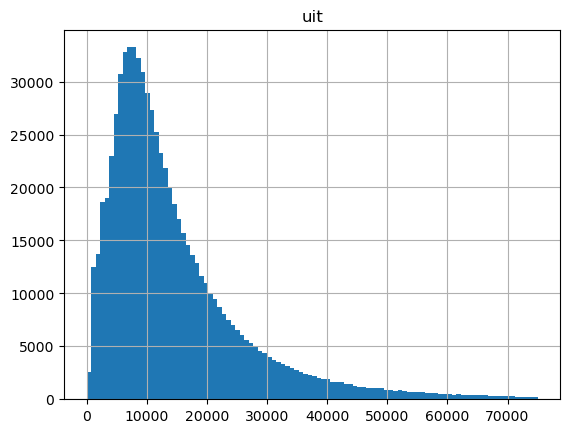

In [38]:
# to get an idea of whether uitspraken and conclusies are roughly the same length
import pandas

p = pandas.DataFrame({#'con':lens_c,
                      'text length':lens_u})

display( p[p>0].count() )
display( p[p>0].sum() )
p[p<75000].hist(bins=100)

u    48000
c     1999
dtype: int64